In [1]:
%matplotlib inline
import time
import random
from random import shuffle
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import itertools
import logging

import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms, datasets, models
from torchvision.datasets import CIFAR10

from scipy.stats import entropy, ks_2samp
from scipy.special import kl_div
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import label_binarize

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import traceback
import copy

In [2]:
logname = 'logs/decentralized_testing'
logging.basicConfig(filename=logname,
                            filemode='a',
                            format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                            datefmt='%H:%M:%S',
                            level=logging.DEBUG)

logging.info("Running Decentralized Learning test")

logger = logging.getLogger('Decentralized_log')

In [3]:
# reproduce randomness for fair comparison
np.random.seed(0)

In [4]:
# Standard transformations for improving CIFAR10. 

# Transformations
RC   = transforms.RandomCrop(32, padding=4)
RHF  = transforms.RandomHorizontalFlip()
RVF  = transforms.RandomVerticalFlip()
NRM  = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT   = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug   = transforms.Compose([TT, NRM])

# Downloading/Louding CIFAR10 data
trainset = torchvision.datasets.CIFAR10(root='../data/cifar10', train=True,
                                        download=True, transform=transform_with_aug)

testset = torchvision.datasets.CIFAR10(root='../data/cifar10', train=False,
                                       download=True, transform=transform_no_aug)

classDict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

# Separating trainset/testset data/label
x_train  = trainset.data
x_test   = testset.data
y_train  = trainset.targets
y_test   = testset.targets

# Define a function to separate CIFAR classes by class index

def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:,0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]
    
    return x_i

class DatasetMaker(Dataset):
    def __init__(self, datasets, transformFunc = transform_no_aug):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths  = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)
    
    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index  = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# If we are saving a fraction of random data to be used in training
frac = int(len(x_train) * 0.05)
x_reserve = x_train[:frac]
y_reserve = y_train[:frac]
x_train = x_train[frac:]
y_train = y_train[frac:]

In [6]:
# ================== Usage ================== #

# Let's choose cats (class 3 of CIFAR) and dogs (class 5 of CIFAR) as trainset/testset
trainset1 = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['plane']), 
         get_class_i(x_train, y_train, classDict['car']), 
         get_class_i(x_train, y_train, classDict['bird']), 
         get_class_i(x_train, y_train, classDict['cat']), 
         get_class_i(x_train, y_train, classDict['deer']),
        [],[],[],[],[]],
        transform_with_aug
    )
trainset2 = \
    DatasetMaker(
        [[],[],[],[],[],
         get_class_i(x_train, y_train, classDict['dog']), 
         get_class_i(x_train, y_train, classDict['frog']), 
         get_class_i(x_train, y_train, classDict['horse']), 
         get_class_i(x_train, y_train, classDict['ship']), 
         get_class_i(x_train, y_train, classDict['truck'])],
        transform_with_aug
    )
trainset3 = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['plane']), 
         get_class_i(x_train, y_train, classDict['car']), 
         get_class_i(x_train, y_train, classDict['bird']), 
         get_class_i(x_train, y_train, classDict['cat']), 
         get_class_i(x_train, y_train, classDict['deer']),
         get_class_i(x_train, y_train, classDict['dog']), 
         get_class_i(x_train, y_train, classDict['frog']), 
         get_class_i(x_train, y_train, classDict['horse']), 
         get_class_i(x_train, y_train, classDict['ship']), 
         get_class_i(x_train, y_train, classDict['truck'])],
        transform_with_aug
    )
reserved = \
    DatasetMaker(
        [get_class_i(x_reserve, y_reserve, classDict['plane']), 
         get_class_i(x_reserve, y_reserve, classDict['car']), 
         get_class_i(x_reserve, y_reserve, classDict['bird']), 
         get_class_i(x_reserve, y_reserve, classDict['cat']), 
         get_class_i(x_reserve, y_reserve, classDict['deer']),
         get_class_i(x_reserve, y_reserve, classDict['dog']), 
         get_class_i(x_reserve, y_reserve, classDict['frog']), 
         get_class_i(x_reserve, y_reserve, classDict['horse']), 
         get_class_i(x_reserve, y_reserve, classDict['ship']), 
         get_class_i(x_reserve, y_reserve, classDict['truck'])],
        transform_with_aug
    )
testset  = \
    DatasetMaker(
        [get_class_i(x_test, y_test, classDict['plane']), 
         get_class_i(x_test, y_test, classDict['car']), 
         get_class_i(x_test, y_test, classDict['bird']), 
         get_class_i(x_test, y_test, classDict['cat']), 
         get_class_i(x_test, y_test, classDict['deer']),
         get_class_i(x_test, y_test, classDict['dog']), 
         get_class_i(x_test, y_test, classDict['frog']), 
         get_class_i(x_test, y_test, classDict['horse']), 
         get_class_i(x_test, y_test, classDict['ship']), 
         get_class_i(x_test, y_test, classDict['truck'])],
        transform_no_aug
    )

superset = torch.utils.data.ConcatDataset([trainset2,reserved])

kwargs = {'num_workers': 2, 'pin_memory': False}

# Create datasetLoaders from trainset and testset
trainsetLoader1   = DataLoader(trainset1, batch_size=64, shuffle=True , **kwargs)
trainsetLoader2   = DataLoader(trainset2, batch_size=64, shuffle=True , **kwargs)
trainsetLoader3   = DataLoader(trainset3, batch_size=64, shuffle=True , **kwargs)
reservedLoader    = DataLoader(superset, batch_size=64, shuffle=True , **kwargs)
testsetLoader    = DataLoader(testset , batch_size=64, shuffle=False, **kwargs)

In [7]:
def imshow(img):
    img = img / 2 + 0.3    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#### Test that things are working

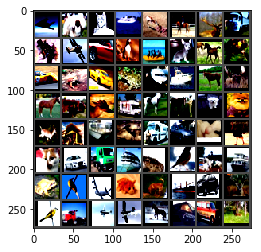

In [8]:
img, label = next(iter(trainsetLoader3))
imshow(torchvision.utils.make_grid(img))

#### Decide on a GPU to use

In [9]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

# device2 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Decentralized Pairwise Knowledge Transfer

## Define the local training process

In [10]:
### Hooks are used to investigate the effect of gradiant decent on weights. Not necessary for simply reproducing paper results. 
grad_dict: dict = {}
def fc_hook(layer_name, grad_input, grad_output): 
    if layer_name not in grad_dict:
        grad_dict[layer_name] = {}
        grad_dict[layer_name]["grad_input"] = []
        grad_dict[layer_name]["grad_output"] = []
        grad_dict[layer_name]["labels"] = []
        
#     print(grad_input)
#     print(grad_output)
    grad_dict[layer_name]["grad_input"].append(grad_input[0].cpu().numpy())
    grad_dict[layer_name]["grad_output"].append(grad_output[0].cpu().numpy())



def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    writer = SummaryWriter('runs/') 

    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].sampler), 
                     'valid': len(dataloders['valid'].sampler)}

    i = 0
    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    ## Tensorboard
#                     writer.add_histogram('distribution centers/resnet2', model.fc.weight.cpu().detach().numpy(), i)
                    i+=1
                    ## Back prop gook
                    grad_dict["fc"]["labels"].append(labels.cpu().numpy())

                
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
                
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects.double() / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    writer.close()
    model.load_state_dict(best_model_wts)
    return model

In [11]:
resnet = models.resnet50(pretrained=False)
# freeze all model parameters
# for param in resnet.parameters():
#     param.requires_grad = False

# new final layer with 16 classes
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 10)

def fc_backward_hook(module, grad_input, grad_output):  # module is Linear in this case. Ignored.
        fc_hook("fc", grad_input, grad_output)
resnet.fc_hook_handle = resnet.fc.register_backward_hook(fc_backward_hook)

resnet = resnet.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999))
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7000, gamma=0.1)

dloaders = {'train':trainsetLoader3, 'valid':testsetLoader}

In [12]:
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=190)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

/home/ogoldstein/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch [0/189] train loss: 0.0344 acc: 0.2308 valid loss: 0.0290 acc: 0.3359
Epoch [1/189] train loss: 0.0290 acc: 0.3367 valid loss: 0.0261 acc: 0.3951
Epoch [2/189] train loss: 0.0268 acc: 0.3811 valid loss: 0.0247 acc: 0.4244
Epoch [3/189] train loss: 0.0252 acc: 0.4172 valid loss: 0.0224 acc: 0.4728
Epoch [4/189] train loss: 0.0240 acc: 0.4462 valid loss: 0.0218 acc: 0.4926
Epoch [5/189] train loss: 0.0231 acc: 0.4693 valid loss: 0.0211 acc: 0.5089
Epoch [6/189] train loss: 0.0224 acc: 0.4868 valid loss: 0.0204 acc: 0.5276
Epoch [7/189] train loss: 0.0216 acc: 0.5032 valid loss: 0.0201 acc: 0.5359
Epoch [8/189] train loss: 0.0211 acc: 0.5197 valid loss: 0.0194 acc: 0.5560
Epoch [9/189] train loss: 0.0205 acc: 0.5328 valid loss: 0.0191 acc: 0.5685
Epoch [10/189] train loss: 0.0200 acc: 0.5473 valid loss: 0.0189 acc: 0.5750
Epoch [11/189] train loss: 0.0195 acc: 0.5569 valid loss: 0.0190 acc: 0.5723
Epoch [12/189] train loss: 0.0190 acc: 0.5676 valid loss: 0.0194 acc: 0.5717
Epoch [13

In [17]:
# resnet1 = copy.deepcopy(resnet)
# dloaders1 = copy.deepcopy(dloaders)
# grad_dict1 = copy.deepcopy(grad_dict)

In [39]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['validA']):
        inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(inputs.cpu().data[j])
            ax.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


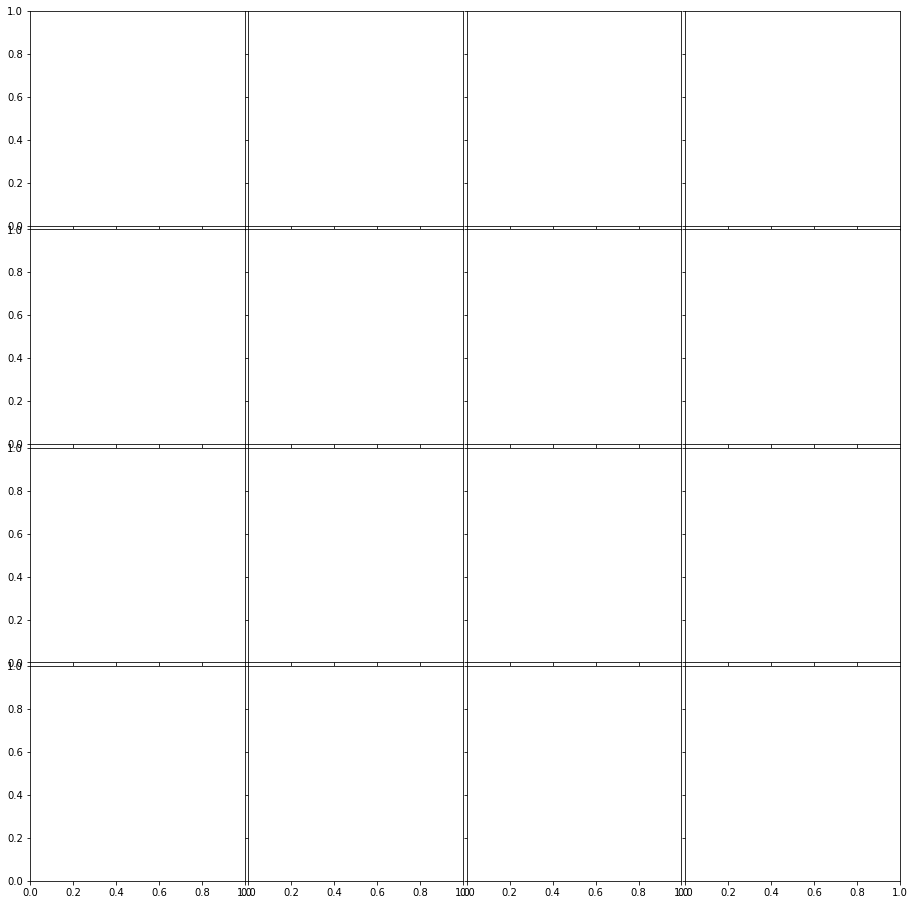

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


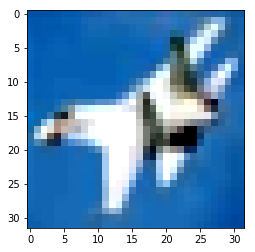

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


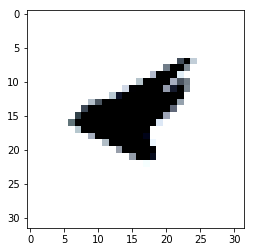

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


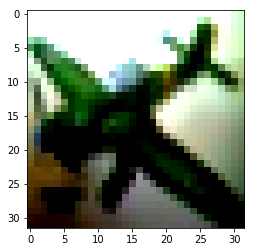

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


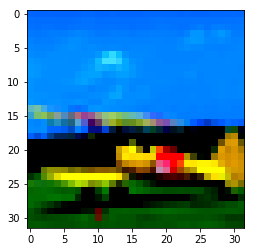

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


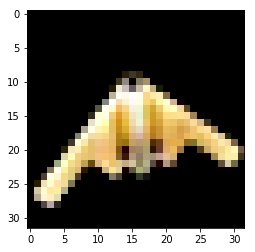

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


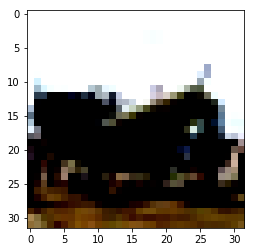

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


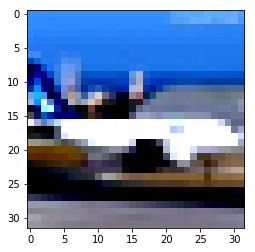

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


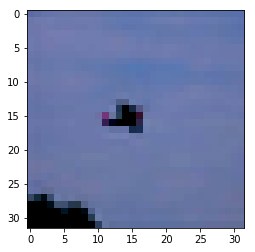

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


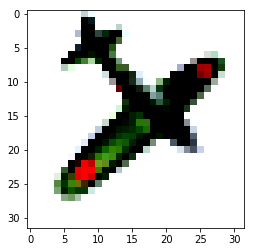

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


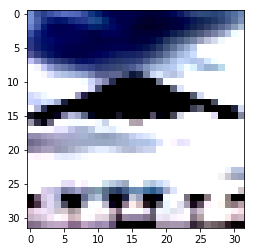

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


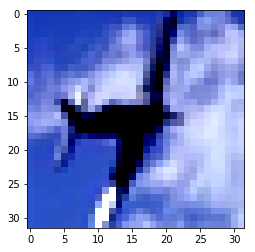

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


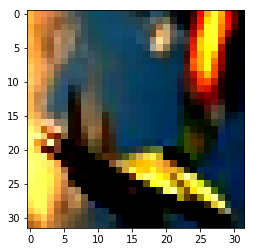

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


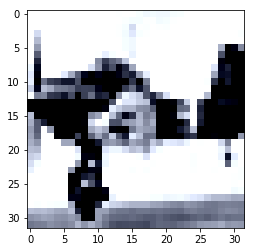

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


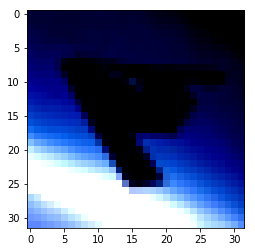

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


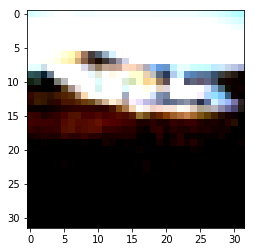

In [40]:
visualize_model(dloaders, resnetA)

### Save models

In [12]:
# train.to_csv('data/dog_breed/train.pt')
# valid.to_csv('data/dog_breed/valid.pt')

In [11]:
PATH = 'data/dog_breed/resnet3_cifar.pt'
torch.save({'model_state_dict': resnet.state_dict()}, PATH)

with open('data/dog_breed/grad_dict3_cifar.pkl', 'wb') as handle:
    pickle.dump(grad_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
##

## Investigation of layers

In [18]:
for p in resnet.named_parameters():
    print(p[0])

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

### Load 3 models -> resnet 1 and resnet 2 trained on discrete data and resnet 3 trained on all data

In [8]:
dldr = []
resnets = []
grad_dicts = []


for i in range(2):
    ## Load the models
    resnet = models.resnet50(pretrained=True)
    # freeze all model parameters
    # for param in resnet.parameters():
    #     param.requires_grad = False

    # new final layer with 16 classes
    num_ftrs = resnet.fc.in_features
    resnet.fc = torch.nn.Linear(num_ftrs, 32)
        
    resnet = resnet.to(device)

    PATH = 'data/dog_breed/resnet'+str(i+1)+'_cifar.pt'
    checkpoint = torch.load(PATH)
    resnet.load_state_dict(checkpoint['model_state_dict'])
    resnets.append(resnet)
    
#     with open('data/dog_breed/grad_dict'+str(i+1)+'_cifar.pkl', 'rb') as handle:
#         grad_dicts.append(pickle.load(handle))
    
resnet1 = resnets[0]
# grad_dict1 = grad_dicts[0]

resnet2 = resnets[1]
# grad_dict2 = grad_dicts[1]

# resnet3 = resnets[2]
# dloaders3 = dloaders = {'train':trainsetLoader3, 'valid':testsetLoader}
# grad_dict3 = grad_dicts[2]

dloaders = {'train':trainsetLoader2, 'valid':testsetLoader}

del(checkpoint)
del(resnets)
torch.cuda.empty_cache()
print("done")

done


## compare final layer distribution

In [9]:
for p in resnet.named_parameters():
    print(p[0])

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [10]:
first = resnet1.layer1[0].conv1.weight.cpu().detach().numpy()
second = resnet2.layer1[0].conv1.weight.cpu().detach().numpy()
# third = resnet3.fc.weight.cpu().detach().numpy()

In [11]:
ks_2samp(first.flatten(), second.flatten())

Ks_2sampResult(statistic=0.0146484375, pvalue=0.7688935400020491)

In [19]:
ks_2samp(first.flatten(), third.flatten())

Ks_2sampResult(statistic=0.131988525390625, pvalue=0.0)

In [17]:
x = np.random.normal(0, 1, first.flatten().shape)
y = np.random.normal(0, 1.1, first.flatten().shape)

In [ ]:
ks_2samp(first.flatten(), x)

In [18]:
ks_2samp(x, y)

Ks_2sampResult(statistic=0.01953125, pvalue=0.8260445282518181)

## Switching layers

In [9]:
def test_model(dataloders, model, criterion, phase='valid'):
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}
    features = []
    model.train(False)

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloders[phase]:
        
        inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    valid_epoch_loss = running_loss / dataset_sizes[phase]
    valid_epoch_acc = running_corrects.double() / dataset_sizes[phase]

    print('Epoch [{}/{}] valid loss: {:.4f} acc: {:.4f}'.format(
            0, 0 - 1,
            valid_epoch_loss, valid_epoch_acc))
    
    return valid_epoch_acc

In [10]:
temp = copy.deepcopy(resnet2)

In [96]:
# num_ftrs = resnet1.fc.in_features
# resnet.fc = torch.nn.Linear(num_ftrs, 32)

temp.fc.weight = torch.nn.Parameter(torch.cat((temp.fc.weight, temp.fc.weight)))
temp.fc.bias = torch.nn.Parameter(torch.cat((temp.fc.bias, temp.fc.bias)))

In [98]:
newfc = (temp.layer1[0].conv1.weight + resnet1.layer1[0].conv1.weight)/2
newbi = (temp.layer1[0].bn1.weight + resnet1.layer1[0].bn1.weight)/2

In [99]:
temp.layer1[0].conv1.weight = torch.nn.Parameter(newfc)
temp.layer1[0].bn1.weight = torch.nn.Parameter(newbi)

In [66]:
temp.fc = copy.deepcopy(decenter.translation[-1])

In [11]:
criterion = torch.nn.CrossEntropyLoss()
test_model(dloaders, temp, criterion)

Epoch [0/-1] valid loss: 0.3725 acc: 0.0410


tensor(0.0410, device='cuda:3', dtype=torch.float64)

In [ ]:
0.4926

In [ ]:
0.9276

In [ ]:
0.9125

## Mutual info between layer and targets

In [27]:
features_in1_1 = []
features_in1_2 = []
features_out1 = []
labels1 = []

features_in2_1 = []
features_in2_2 = []
features_out2 = []
labels2 = []

for l in grad_dict1['fc']['labels']:
    labels1 += list(l.cpu().numpy())
    
for f in grad_dict1['fc']['grad_input']:
    features_in1_1 += list(f[1].cpu().numpy())
    
for f in grad_dict1['fc']['grad_input']:
    features_in1_2 += list(f[2].cpu().numpy().flatten())
    
for f in grad_dict1['fc']['grad_output']:
    features_out1 += list(f[0].cpu().numpy())
    
for l in grad_dict2['fc']['labels']:
    labels2 += list(l.cpu().numpy())
    
for f in grad_dict2['fc']['grad_input']:
    features_in2_1 += list(f[1].cpu().numpy())
    
for f in grad_dict2['fc']['grad_input']:
    features_in2_2 += list(f[2].cpu().numpy().flatten())
    
for f in grad_dict2['fc']['grad_output']:
    features_out2 += list(f[0].cpu().numpy())

In [308]:
grad_dict1['fc']['grad_input'][0][1].shape

torch.Size([4, 2048])

In [38]:
grad_dict['fc']['grad_output'][0][0]

tensor([[ 0.0037,  0.0070,  0.0075,  0.0096,  0.0057, -0.2386,  0.0080,  0.0086,
          0.0057,  0.0041,  0.0097,  0.0054,  0.0067,  0.0077,  0.0095,  0.0088,
          0.0073,  0.0066,  0.0144,  0.0101,  0.0093,  0.0072,  0.0082,  0.0073,
          0.0099,  0.0103,  0.0064,  0.0045,  0.0062,  0.0064,  0.0078,  0.0089],
        [ 0.0034,  0.0126,  0.0060,  0.0090,  0.0043,  0.0168,  0.0067,  0.0114,
         -0.2440,  0.0048,  0.0117,  0.0060,  0.0069,  0.0059,  0.0068,  0.0044,
          0.0103,  0.0072,  0.0115,  0.0081,  0.0083,  0.0072,  0.0096,  0.0073,
          0.0059,  0.0118,  0.0097,  0.0048,  0.0052,  0.0071,  0.0065,  0.0070],
        [-0.2473,  0.0067,  0.0063,  0.0105,  0.0041,  0.0106,  0.0099,  0.0105,
          0.0054,  0.0039,  0.0079,  0.0049,  0.0050,  0.0047,  0.0079,  0.0074,
          0.0100,  0.0111,  0.0169,  0.0119,  0.0086,  0.0073,  0.0095,  0.0072,
          0.0055,  0.0095,  0.0071,  0.0038,  0.0091,  0.0054,  0.0065,  0.0121],
        [ 0.0045,  0.0074

In [183]:
# sm = torch.nn.AdaptiveLogSoftmaxWithLoss(dim=1)
# res = sm(grad_dict['fc']['grad_input'][0][1])

In [13]:
muinfo_in1_1 = mutual_info_classif(features_in1_1, labels1)
muinfo_in2_1 = mutual_info_classif(features_in2_1, labels2)

In [31]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=10, criterion='gini')
clf = clf.fit(features_in2_1, labels2)
clf.feature_importances_

array([1.62526113e-04, 2.77214234e-04, 6.08867836e-05, ...,
       3.59420691e-04, 2.91093681e-04, 2.47651826e-04])

In [417]:
from sklearn.linear_model import LassoCV
clf = LassoCV(cv=5, random_state=24, max_iter=3000)
clf.fit(features_in2_1, labels2)
clf.coef_

/home/ogoldstein/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([ 0.,  0.,  0., ..., -0.,  0.,  0.])

In [127]:
lst = list(range(2048))
shuffle(lst)

In [413]:
bzz = abs(temp.fc.weight - resnet1.fc.weight)

In [36]:
varz = resnet1.fc.weight.var(axis=0).argsort()

In [40]:
target = varz.cpu().numpy()
# source = muinfo_in1_1.argsort()[-2048:][::-1]
for i in range(len(temp.fc.weight)):
    for j in range(2048):
        alpha = 1.0 - (j/2048)
        temp.fc.weight[i][target[j]] = ((alpha*temp.fc.weight[i][target[j]])+((1-alpha)*resnet1.fc.weight[i][target[j]]))/2

In [142]:
lst = copy.deepcopy(lst_max)

# Decentralized model

In [9]:
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

class Decenter(torch.nn.Module):

    def __init__(self, source, target):
        super(Decenter, self).__init__()
        self.translation = torch.nn.Sequential(
#           View((-1, 256*1*1)),                 # B, 256
            source,
            torch.nn.Tanh(),
            torch.nn.Linear(source.out_features, target.in_features),
            torch.nn.Tanh(),
#             torch.nn.Linear(1024, target.in_features),
            target,
#             torch.nn.Linear(source.out_features, source.in_features),
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        res = self.translation(x)
        return res

In [10]:
def run_dec(model, criterion, optimizer, input_shape, num_iter = 1000):
    writer = SummaryWriter('runs/') 
    model.train(True)
    dataset_sizes = {'train': len(dloaders['train'].dataset), 
                     'valid': len(dloaders['valid'].dataset)}

    for i in range(num_iter):
        
#         loss = criterion(model.translation[-1].weight, resnet3.fc.weight) + \
#                criterion(model.translation[-1].bias, resnet3.fc.bias)

        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dloaders['valid']:
        
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

            x = Variable(FloatTensor(np.random.normal(0, 1, input_shape)))
            optimizer.zero_grad()
            model(x)
            
            temp.fc = copy.deepcopy(model.translation[-1])
            outputs = temp(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

            valid_epoch_loss = running_loss / dataset_sizes['valid']
            valid_epoch_acc = running_corrects.double() / dataset_sizes['valid']
            
            loss.backward()
            optimizer.step()

        print('Epoch [{}/{}] valid loss: {:.4f} acc: {:.4f}'.format(
                i, num_iter - 1,
                valid_epoch_loss, valid_epoch_acc))
        
#         ## Tensorboard
#         writer.add_histogram('distribution learning3/decenter_2nd_layer', decenter.translation[2].weight.cpu().detach().numpy(), i)
#         writer.add_histogram('distribution learning3/decenter_4th_layer', decenter.translation[4].weight.cpu().detach().numpy(), i)
        
        print('loss: {:.10f}'.format(loss))
    
    writer.close()
    return model

In [21]:
decenter = Decenter(resnet1.fc, resnet2.fc)
list(decenter.parameters())

[Parameter containing:
 tensor([[ 0.0243,  0.0093,  0.0318,  ...,  0.0431, -0.0191,  0.0068],
         [-0.0090,  0.0001,  0.0477,  ...,  0.0389,  0.0284,  0.0320],
         [-0.0100,  0.0125,  0.0070,  ..., -0.0210, -0.0067,  0.0088],
         ...,
         [-0.0120,  0.0143,  0.0190,  ..., -0.0067, -0.0049,  0.0030],
         [-0.0203, -0.0088, -0.0110,  ..., -0.0207,  0.0189, -0.0215],
         [ 0.0108,  0.0158,  0.0150,  ...,  0.0186, -0.0031,  0.0025]],
        device='cuda:3', requires_grad=True), Parameter containing:
 tensor([-0.0144, -0.0375,  0.0456,  0.0542,  0.0569, -0.0082, -0.0167, -0.0244,
         -0.0043,  0.0004, -0.0237, -0.0216, -0.0104,  0.0142, -0.0114, -0.0137,
         -0.0221, -0.0076,  0.0187,  0.0091, -0.0145,  0.0035, -0.0093,  0.0040,
         -0.0126, -0.0064, -0.0178,  0.0173, -0.0073, -0.0021,  0.0151,  0.0183],
        device='cuda:3', requires_grad=True), Parameter containing:
 tensor([[ 0.0581,  0.1380,  0.1573,  ..., -0.0923,  0.0112, -0.1472],
    

In [ ]:
cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

decenter = Decenter(copy.deepcopy(resnet1.fc), copy.deepcopy(resnet2.fc))
temp = copy.deepcopy(resnet2)
# freeze all model parameters
# for param in decenter.parameters():
#     param.requires_grad = False
decenter.translation[0].weight.requires_grad = False
decenter.translation[0].bias.requires_grad = False

decenter.to(device)
# crit = torch.nn.functional.kl_div
# crit = torch.nn.MSELoss(reduction="sum")
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(decenter.parameters(), lr=0.1, momentum=0.9)

decenter = run_dec(decenter, criterion, opt, resnet1.fc.weight.shape, num_iter=200)

# Decentralized model using reserved data

## Train a knowledge transfer model

In [53]:
def kaiming_init(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d)):
        torch.nn.init.sparse_(m.weight, sparsity=0.5)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

class Decenter(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter, self).__init__()
        if len(shape) == 1:
            shape = shape[0]
            self.dim = 0
        elif len(shape) == 2:
            shape = shape[1]
            self.dim = 1
        self.translation = torch.nn.Sequential(
#             torch.nn.Tanh(),
            torch.nn.Linear(shape*2, shape)
        )

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source, target):
        x = torch.cat((source, target), self.dim)
#         x = torch.cat((torch.flatten(source), torch.flatten(target)), 0)
#         x = torch.add(torch.flatten(source).to("cpu"), torch.flatten(target).to("cpu"))
        res = self.translation(x)
#         res = res.reshape(target.shape)
        return res
    
    
class Interpolate(torch.nn.Module):
    def __init__(self, size, mode):
        super(Interpolate, self).__init__()
        self.interp = torch.nn.functional.interpolate
        self.size = size
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, size=self.size, mode=self.mode, align_corners=False)
        return x
    
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
class Decenter_pooled(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter_pooled, self).__init__()
        self.shape = shape
        self.translation = torch.nn.Sequential(
#             torch.nn.BatchNorm2d(channels_out),
            torch.nn.AdaptiveAvgPool2d(1),
#             Interpolate(size=1, mode='bilinear'),
            Reshape(shape[0], shape[1]*2),
            torch.nn.Linear(shape[1]*2, shape[1]*shape[-1]*shape[-1]),
#             Reshape(shape[0], shape[1] ,1 ,1),
        )

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source, target):
        x = torch.cat((source, target), 1)
        res = self.translation(x)
        res = res.view(self.shape[0], self.shape[1], self.shape[2], self.shape[3])
        return res
    
    
class Decenter_conv(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter_conv, self).__init__()
        channels_in = shape[1]*2
        channels_out = shape[1]
        self.translation = torch.nn.Sequential(
            torch.nn.BatchNorm2d(channels_in),
            torch.nn.Conv2d(channels_in, channels_in*2, 3, stride=1, padding=1),
            torch.nn.ConvTranspose2d(channels_in*2, channels_out, 3, stride=1, padding=1)

        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source, target):
        x = torch.cat((source, target), 1)
#         x = torch.cat((torch.flatten(source), torch.flatten(target)), 0)
#         x = torch.add(torch.flatten(source).to("cpu"), torch.flatten(target).to("cpu"))
        res = self.translation(x)
        return res

In [54]:
grad_dict: dict = {}
def fc_hook(layer_name, grad_input, grad_output): 
    if layer_name not in grad_dict:
        grad_dict[layer_name] = {}
        grad_dict[layer_name]["grad_input"] = []
        grad_dict[layer_name]["grad_output"] = []
        grad_dict[layer_name]["labels"] = []
        
#     print(grad_input)
#     print(grad_output)
    grad_dict[layer_name]["grad_input"].append(grad_input[0].cpu().numpy())
    grad_dict[layer_name]["grad_output"].append(grad_output[0].cpu().numpy())
    
# def reserve_step(source, target):
    

matlst = []
fclst = []

def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    writer = SummaryWriter('runs/') 

    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = 0.0
    best_acc = 0.0
    dataset_sizes = {'trainA': len(dataloders['trainA'].sampler),
                     'trainB': len(dataloders['trainB'].sampler),
                     'reservedA': len(dataloders['reservedA'].sampler),
                     'reservedB': len(dataloders['reservedB'].sampler),
                     'validA': len(dataloders['validA'].sampler),
                     'validB': len(dataloders['validB'].sampler)}

    i = 0
    for epoch in range(num_epochs):
        for phase in ['trainA', 'validA', 'trainB', 'validB', 'reservedB', 'validB']:
            if phase != 'validA' and phase != 'validB':
                scheduler[phase].step()
                scheduler[phase].step()
                model[phase].train(True)
            else:
                model['trainA'].train(False)
                model['trainB'].train(False)
            
            
            running_loss = 0.0
            running_corrects = 0
            
            if phase == 'reservedA' or phase == 'reservedB':
                    sd = model[phase].state_dict()
                    for key, value in mdlz.items():
                        shape = model['trainB'].state_dict()[key].shape
                        mdl = value[1](shape).to(device)
                        checkpoint = torch.load(value[0])
                        mdl.load_state_dict(checkpoint['model_state_dict'])
                        mdl.eval()
                        sd[key] = mdl(copy.deepcopy(model['trainA'].state_dict()[key]), copy.deepcopy(model['trainB'].state_dict()[key]))
#                         torch.save({'model_state_dict': mdl.state_dict()}, value[0])
                        
                        if key == 'conv1.weight':
                            matlst.append(sd[key])
                        elif key == 'fc.weight':
                            fclst.append(sd[key])
                        
                    model[phase].load_state_dict(sd)
                    
                    
            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer[phase].zero_grad()

                outputs = model[phase](inputs)
                _, preds = torch.max(outputs.data, 1)
                
                if phase == 'reservedB':
                    loss_a = criterion['trainB'](outputs, labels)
#                     batch_size = labels.shape[0]
#                     # Dummy input that HAS to be 2D for the scatter (you can use view(-1,1) if needed)
#                     y = labels.reshape(-1,1)
#                     # One hot encoding buffer that you create out of the loop and just keep reusing
#                     y_onehot = torch.FloatTensor(batch_size, 10).to(device)

#                     # In your for loop
#                     y_onehot.zero_()
#                     y_onehot.scatter_(1, y, 1)

                    outputs2 = model['trainA'](inputs)
    
                    sm = torch.nn.Softmax(dim=1)
                    outputs = sm(outputs)
                    outputs2 = sm(outputs2)
                    loss_b = criterion[phase](outputs, outputs2)
                    loss = (loss_a + loss_b) / 2
                else:
                    loss = criterion[phase](outputs, labels)

                if phase != 'validA' and phase != 'validB':
                    loss.backward(retain_graph=False)
                    optimizer[phase].step()
                    
                    if phase == 'reservedB':
#                         loss_b.backward(retain_graph=False)
                        for key, value in mdlz.items():
                            shape = model['trainB'].state_dict()[key].shape
                            mdl = value[1](shape).to(device)
                            opti = torch.optim.AdamW(mdl.parameters(), lr=0.001, betas=(0.9, 0.999))
                            checkpoint = torch.load(value[0])
                            mdl.load_state_dict(checkpoint['model_state_dict'])
                            mdl.eval()
                            opti.load_state_dict(checkpoint['optimizer_state_dict'])
#                             opti.zero_grad()
                            opti.step()
                            torch.save({'model_state_dict': mdl.state_dict(),
                                        'optimizer_state_dict': opti.state_dict()},
                                       value[0])
                            
                    ## Tensorboard
#                     writer.add_histogram('distribution centers/resnet2', model.fc.weight.cpu().detach().numpy(), i)
                    i+=1
                    ## Back prop hook
#                     grad_dict["fc"]["labels"].append(labels.cpu().numpy())

                
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
                
            if phase != 'validA' and phase != 'validB':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects.double() / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('Epoch [{}/{}] phase: {} train loss: {:.4f} acc: {:.4f} ' 
                      'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        phase,
                        train_epoch_loss, train_epoch_acc, 
                        valid_epoch_loss, valid_epoch_acc))
                print() 
                logger.info('Epoch [{}/{}] phase: {} train loss: {:.4f} acc: {:.4f} ' 
                      'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        phase,
                        train_epoch_loss, train_epoch_acc, 
                        valid_epoch_loss, valid_epoch_acc))
                
            if phase == 'validA' or phase == 'validB' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model[phase].state_dict()

                
    print('Best val Acc: {:4f}'.format(best_acc))
    logger.info('Best val Acc: {:4f}'.format(best_acc))

    writer.close()
#     model.load_state_dict(best_model_wts)
    return model

In [55]:
resnetA = models.resnet18(pretrained=False)
resnetB = models.resnet18(pretrained=False)
# freeze all model parameters
# for param in resnet.parameters():
#     param.requires_grad = False

# new final layer with 16 classes
num_ftrsA = resnetA.fc.in_features
resnetA.fc = torch.nn.Linear(num_ftrsA, 10)

num_ftrsB = resnetB.fc.in_features
resnetB.fc = torch.nn.Linear(num_ftrsB, 10)

def fc_backward_hook(module, grad_input, grad_output):  # module is Linear in this case. Ignored.
        fc_hook("fc", grad_input, grad_output)
resnetA.fc_hook_handle = resnetA.fc.register_backward_hook(fc_backward_hook)
resnetB.fc_hook_handle = resnetB.fc.register_backward_hook(fc_backward_hook)

def roc_auc_score_micro(y_pred_proba, y_true):
    y_pred_proba = y_pred_proba.detach().cpu()
    y_true = y_true.detach().cpu()
    return metrics.roc_auc_score(
        label_binarize(y_true, classes=list(range(y_pred_proba.shape[1]))).ravel(),
        y_pred_proba.flatten())


resnetA = resnetA.to(device)
resnetB = resnetB.to(device)

criterionA = torch.nn.CrossEntropyLoss()
# criterionB = torch.nn.CrossEntropyLoss()
# criterionA = torch.nn.KLDivLoss()
criterionB = torch.nn.KLDivLoss(reduction = 'batchmean')
# criterionB = torch.nn.KLDivLoss(reduction = 'mean')
# criterionB = torch.nn.MSELoss()
# optimizerA = torch.optim.SGD(resnetA.parameters(), lr=0.001, momentum=0.9)
# optimizerB = torch.optim.SGD(resnetB.parameters(), lr=0.001, momentum=0.9)
optimizerA = torch.optim.AdamW(resnetA.parameters(), lr=0.001, betas=(0.9, 0.999))
optimizerB = torch.optim.AdamW(resnetB.parameters(), lr=0.001, betas=(0.9, 0.999))

exp_lr_schedulerA = lr_scheduler.StepLR(optimizerA, step_size=200, gamma=0.1)
exp_lr_schedulerB = lr_scheduler.StepLR(optimizerB, step_size=200, gamma=0.1)


def hwout(Hin, padding, dilation, kernel_size, stride):
    return (Hin + 2 * padding - dilation * (kernel_size-1) - 1)/stride + 1

In [56]:
max_layer = 0
max_neurons = 0
for prm in resnetB.named_parameters():
    num_ftr = np.prod(prm[1].shape)
    if num_ftr > max_neurons:
         max_neurons = num_ftr
         max_layer = prm[1]

In [16]:
[x[0] for x in resnetB.named_parameters()]

['conv1.weight',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.downsample.0.weight',
 'layer2.0.downsample.1.weight',
 'layer2.0.downsample.1.bias',
 'layer2.1.conv1.weight',
 'layer2.1.bn1.weight',
 'layer2.1.bn1.bias',
 'layer2.1.conv2.weight',
 'layer2.1.bn2.weight',
 'layer2.1.bn2.bias',
 'layer3.0.conv1.weight',
 'layer3.0.bn1.weight',
 'layer3.0.bn1.bias',
 'layer3.0.conv2.weight',
 'layer3.0.bn2.weight',
 'layer3.0.bn2.bias',
 'layer3.0.downsample.0.weight',
 'layer3.0.downsample.1.weight',
 'layer3.0.downsample.1.bias',
 'layer3.1.conv1.weight',
 'layer3.1.bn1.

In [57]:
# %%timeit
mdlz = {}
params = []
model_dir = './model_chain'
conv_layers = ['layer4.1.conv2.weight', 'layer4.1.conv1.weight', 'layer4.0.conv2.weight']
bn_layers = ['layer4.1.bn2.bias', 'layer4.1.bn2.weight',
             'layer4.1.bn1.bias', 'layer4.1.bn1.weight',
             'layer4.0.bn2.bias', 'layer4.0.bn2.weight',
             'layer4.0.downsample.0.weight', 'layer4.0.downsample.1.weight', 'layer4.0.downsample.1.bias',
             'fc.weight', 'fc.bias']

for prm in resnetB.named_parameters():
# for prm in temp_list:
    if 'conv' in prm[0] or 'fc' in prm[0] or 'bn' in prm[0] or 'downsample' in prm[0]:
        try:
            if prm[1].dim() > 2:
                if prm[0] not in conv_layers:
                    continue
                mdl = Decenter_conv(prm[1].shape).to(device)
                optimizer = torch.optim.AdamW(mdl.parameters(), lr=0.001, betas=(0.9, 0.999))
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict()},
                           model_dir + '/' + prm[0])
                mdlz[prm[0]] = (model_dir + '/' + prm[0], Decenter_conv)
#                 params += mdl.parameters()
#                 pass
            else:
#                 if prm[0] not in bn_layers:
#                     continue
                mdl = Decenter(prm[1].shape).to(device)
                optimizer = torch.optim.AdamW(mdl.parameters(), lr=0.001, betas=(0.9, 0.999))
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict()},
                           model_dir + '/' + prm[0])
                mdlz[prm[0]] = (model_dir + '/' + prm[0], Decenter)
#                 params += mdl.parameters()
            
            del mdl
            torch.cuda.empty_cache()
        except Exception as e:
            print("Problem with: " + prm[0] + " Size: " + str(prm[1].dim()))
            print("Error: " + str(e))
            traceback.print_exc()
            print()
            pass
        
# params += list(resnetB.parameters())

# optimizerRB = torch.optim.SGD(params, lr=0.01, momentum=0.9)
optimizerRB = torch.optim.AdamW(resnetB.parameters(), lr=0.001, betas=(0.9, 0.999))

In [58]:
mdlz

{'bn1.weight': ('./model_chain/bn1.weight', __main__.Decenter),
 'bn1.bias': ('./model_chain/bn1.bias', __main__.Decenter),
 'layer1.0.bn1.weight': ('./model_chain/layer1.0.bn1.weight',
  __main__.Decenter),
 'layer1.0.bn1.bias': ('./model_chain/layer1.0.bn1.bias', __main__.Decenter),
 'layer1.0.bn2.weight': ('./model_chain/layer1.0.bn2.weight',
  __main__.Decenter),
 'layer1.0.bn2.bias': ('./model_chain/layer1.0.bn2.bias', __main__.Decenter),
 'layer1.1.bn1.weight': ('./model_chain/layer1.1.bn1.weight',
  __main__.Decenter),
 'layer1.1.bn1.bias': ('./model_chain/layer1.1.bn1.bias', __main__.Decenter),
 'layer1.1.bn2.weight': ('./model_chain/layer1.1.bn2.weight',
  __main__.Decenter),
 'layer1.1.bn2.bias': ('./model_chain/layer1.1.bn2.bias', __main__.Decenter),
 'layer2.0.bn1.weight': ('./model_chain/layer2.0.bn1.weight',
  __main__.Decenter),
 'layer2.0.bn1.bias': ('./model_chain/layer2.0.bn1.bias', __main__.Decenter),
 'layer2.0.bn2.weight': ('./model_chain/layer2.0.bn2.weight',
  __

In [59]:
### Define phases 
dloaders = {'trainA':trainsetLoader1, 'trainB':reservedLoader,
            'validA':testsetLoader, 'validB':testsetLoader,
            'reservedA':reservedLoader, 'reservedB':reservedLoader}
model = {'trainA':resnetA, 'trainB':resnetB,
         'validA':resnetA, 'validB':resnetB,
         'reservedA':resnetA, 'reservedB':resnetB}
optimizer = {'trainA':optimizerA, 'trainB':optimizerB,
             'validA':optimizerA, 'validB':optimizerB,
             'reservedA':optimizerA, 'reservedB':optimizerRB}
criterion = {'trainA':criterionA, 'trainB':criterionA,
             'validA':criterionA, 'validB':criterionA,
             'reservedA':criterionB, 'reservedB':criterionB}
exp_lr_scheduler = {'trainA':exp_lr_schedulerA, 'trainB':exp_lr_schedulerB,
             'validA':exp_lr_schedulerA, 'validB':exp_lr_schedulerB,
             'reservedA':exp_lr_schedulerA, 'reservedB':exp_lr_schedulerB}

In [42]:
list(resnetB.named_parameters())[-5][1]

Parameter containing:
tensor([[[[ 2.9589e-03,  6.8022e-03,  2.2719e-02],
          [ 2.2230e-03, -1.2027e-03, -1.8642e-02],
          [-3.2153e-02,  8.9182e-03, -3.1532e-03]],

         [[-7.1234e-03,  1.8497e-03, -8.2703e-03],
          [ 3.8901e-03,  3.1378e-02,  1.2458e-02],
          [-1.6187e-03,  1.3058e-02,  1.0195e-02]],

         [[ 1.3417e-02,  3.8411e-02,  4.8358e-02],
          [ 2.2677e-02,  1.2798e-02, -4.9706e-03],
          [ 8.1029e-03,  1.2481e-02,  1.0438e-02]],

         ...,

         [[-4.6951e-03,  5.5655e-03,  2.0932e-02],
          [ 2.7588e-02, -3.1101e-02,  5.4803e-03],
          [-4.7391e-04, -1.7280e-02, -2.6042e-02]],

         [[-8.4624e-03,  4.0791e-02,  1.1143e-02],
          [ 5.0354e-02, -1.1658e-02, -8.8718e-03],
          [ 1.8294e-03, -7.9179e-03,  3.6732e-03]],

         [[-2.1571e-02,  1.0524e-02, -2.7876e-02],
          [-1.4938e-02, -6.0237e-03, -1.9892e-02],
          [-9.3590e-04, -2.0481e-02,  4.1128e-03]]],


        [[[ 3.1159e-02,  1.3372

In [43]:
vec = list(resnetB.named_parameters())[-5][1]
vec.shape
vec = torch.cat((vec, vec), 1)
vec.shape

torch.Size([512, 1024, 3, 3])

In [153]:
dd = Decenter_conv(vec.shape).to(device)

In [154]:
dd(vec, vec).shape

torch.Size([64, 6, 7, 7])

In [44]:
channels_in = vec.shape[1]
channels_out = int(vec.shape[1]/2)
vec = torch.nn.BatchNorm2d(channels_in).to(device)(vec)
vec.shape

torch.Size([512, 1024, 3, 3])

In [45]:
vec = torch.nn.Conv2d(channels_in, channels_in*2, 3, stride=1, padding=1).to(device)(vec)
vec = torch.nn.ConvTranspose2d(channels_in*2, channels_out, 3, stride=1, padding=1).to(device)(vec)
vec.shape

torch.Size([512, 512, 3, 3])

In [126]:
key = 'layer4.0.conv2.weight'

In [128]:
model['trainA'].state_dict()[key].shape

torch.Size([512, 512, 3, 3])

In [60]:
logging.info("#### bn acti conv and fc - unlimited bn - adam learning rate 0.002 - scheduler 20 - opt adamw ####")

start_time = time.time()
model = train_model(dloaders, model, criterion, optimizer, exp_lr_scheduler, num_epochs=200)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

/home/ogoldstein/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch [0/199] phase: validA train loss: 0.0174 acc: 0.5457 valid loss: 0.1007 acc: 0.3098

Epoch [0/199] phase: validB train loss: 0.0173 acc: 0.6215 valid loss: 0.0354 acc: 0.3726

Epoch [0/199] phase: validB train loss: -0.0004 acc: 0.6482 valid loss: 0.0343 acc: 0.3926

Epoch [1/199] phase: validA train loss: 0.0136 acc: 0.6577 valid loss: 0.0989 acc: 0.3353

Epoch [1/199] phase: validB train loss: 0.0120 acc: 0.7526 valid loss: 0.0346 acc: 0.4093

Epoch [1/199] phase: validB train loss: -0.0002 acc: 0.7341 valid loss: 0.0301 acc: 0.4088

Epoch [2/199] phase: validA train loss: 0.0120 acc: 0.7045 valid loss: 0.1036 acc: 0.3705

Epoch [2/199] phase: validB train loss: 0.0106 acc: 0.7868 valid loss: 0.0328 acc: 0.4154

Epoch [2/199] phase: validB train loss: -0.0011 acc: 0.7802 valid loss: 0.0302 acc: 0.4119

Epoch [3/199] phase: validA train loss: 0.0110 acc: 0.7334 valid loss: 0.1125 acc: 0.3705

Epoch [3/199] phase: validB train loss: 0.0096 acc: 0.8081 valid loss: 0.0292 acc: 0.43

KeyboardInterrupt: 

## Testing ground

In [ ]:
### Test funciton on conv layers

A = list(resnetA.named_parameters())[-14][1]
B = list(resnetB.named_parameters())[-14][1]
x = torch.cat((A, B), 1)
x.shape

pool = torch.nn.AdaptiveAvgPool2d(1)
inter = Interpolate(size=(1), mode='bilinear')

px = pool(x)
ix = inter(x)

In [81]:
res_max = 0.0
lst_max = []
for i in range(1000):
    temp = copy.deepcopy(resnet2)
    lst = [[i for i in range(2048)] for j in range(32)]
    shuffle([shuffle(c) for c in lst])
    ctr = 0
    target = lst
    # source = muinfo_in1_1.argsort()[-2048:][::-1]
    for i in range(len(temp.fc.weight)):
        for j in range(2048):
            alpha = 1.0 - (j/2048)
            temp.fc.weight[i][target[i][j]] = ((alpha*temp.fc.weight[i][target[i][j]])+((1-alpha)*resnet1.fc.weight[i][target[i][j]]))/2
            ctr += 1
            
    criterion = torch.nn.CrossEntropyLoss()
    acc = test_model(dloaders2, temp, criterion)
    
    if acc > res_max:
        res_max = acc
        lst_max = lst

/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3389 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3378 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3466 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3412 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3406 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3433 acc: 0.8899


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3417 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3462 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3349 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3409 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3357 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3401 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3405 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3460 acc: 0.9186


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3407 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3408 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3436 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3427 acc: 0.9186


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3424 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3451 acc: 0.9216


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3449 acc: 0.8824


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3377 acc: 0.9216


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3428 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3400 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3377 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3383 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3354 acc: 0.9201


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3467 acc: 0.8824


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3436 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3434 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3421 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3414 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3381 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3423 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3418 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3445 acc: 0.9216


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3443 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3397 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3378 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3453 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3389 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3406 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3415 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3412 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3411 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3415 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3421 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3388 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3451 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3356 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3396 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3457 acc: 0.8854


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3405 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3387 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3428 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3492 acc: 0.8793


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3406 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3442 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3413 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3443 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3419 acc: 0.8884


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3460 acc: 0.8884


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3456 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3450 acc: 0.8839


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3447 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3417 acc: 0.8808


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3420 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3425 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3438 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3408 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3486 acc: 0.8869


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3451 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3418 acc: 0.8824


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3418 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3419 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3403 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3475 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3355 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3442 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3446 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3417 acc: 0.9186


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3409 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3441 acc: 0.8884


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3446 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3376 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3410 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3449 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3420 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3413 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3387 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3413 acc: 0.8899


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3419 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3389 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3441 acc: 0.8839


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3417 acc: 0.8808


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3418 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3354 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3455 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3428 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3395 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3374 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3405 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3429 acc: 0.9170


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3363 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3424 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3471 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3427 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3433 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3431 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3395 acc: 0.9170


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3404 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3480 acc: 0.9155


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3427 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3466 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3406 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3430 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3415 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3431 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3466 acc: 0.9155


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3420 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3438 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3444 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3441 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3433 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3441 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3436 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3439 acc: 0.8869


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3430 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3429 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3431 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3442 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3442 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3450 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3392 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3431 acc: 0.9170


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3451 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3417 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3471 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3430 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3408 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3392 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3392 acc: 0.8839


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3407 acc: 0.8869


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3433 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3440 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3429 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3371 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3407 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3420 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3460 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3443 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3380 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3395 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3385 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3372 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3403 acc: 0.8808


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3388 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3441 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3439 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3427 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3440 acc: 0.8899


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3390 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3408 acc: 0.8869


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3410 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3401 acc: 0.8824


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3387 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3384 acc: 0.9246


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3445 acc: 0.9201


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3438 acc: 0.8854


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3403 acc: 0.8869


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3393 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3458 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3416 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3397 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3434 acc: 0.8839


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3453 acc: 0.8899


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3434 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3429 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3393 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3425 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3392 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3453 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3424 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3462 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3451 acc: 0.8839


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3438 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3385 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3414 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3481 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3422 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3400 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3403 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3452 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3446 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3420 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3401 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3406 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3451 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3412 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3450 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3393 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3373 acc: 0.9155


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3421 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3440 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3411 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3374 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3450 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3435 acc: 0.8884


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3455 acc: 0.8824


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3441 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3461 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3450 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3433 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3386 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3429 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3439 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3411 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3443 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3399 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3410 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3476 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3435 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3420 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3355 acc: 0.9155


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3405 acc: 0.8824


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3371 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3403 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3423 acc: 0.9155


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3407 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3413 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3442 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3444 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3418 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3435 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3450 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3415 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3365 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3370 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3407 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3436 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3438 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3391 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3397 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3400 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3395 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3471 acc: 0.8884


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3473 acc: 0.8673


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3442 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3404 acc: 0.9231


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3416 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3407 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3473 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3410 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3433 acc: 0.9155


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3439 acc: 0.8899


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3373 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3401 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3419 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3416 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3475 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3474 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3463 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3431 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3385 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3432 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3348 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3450 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3421 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3388 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3409 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3420 acc: 0.9155


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3392 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3399 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3414 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3408 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3413 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3446 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3440 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3430 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3471 acc: 0.8899


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3401 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3413 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3538 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3414 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3474 acc: 0.8884


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3421 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3397 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3451 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3420 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3496 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3431 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3439 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3446 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3435 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3382 acc: 0.9231


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3372 acc: 0.8884


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3455 acc: 0.8733


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3456 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3422 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3398 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3404 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3381 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3404 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3409 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3427 acc: 0.8824


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3432 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3417 acc: 0.8778


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3409 acc: 0.9170


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3444 acc: 0.8884


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3448 acc: 0.8899


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3446 acc: 0.8763


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3394 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3410 acc: 0.8884


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3464 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3421 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3410 acc: 0.8854


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3434 acc: 0.9201


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3422 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3476 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3454 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3428 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3427 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3497 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3381 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3377 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3475 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3410 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3445 acc: 0.8748


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3418 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3434 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3367 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3433 acc: 0.8899


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3418 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3410 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3416 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3430 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3389 acc: 0.9186


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3376 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3394 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3400 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3440 acc: 0.8899


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3445 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3400 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3431 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3389 acc: 0.8869


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3407 acc: 0.9170


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3441 acc: 0.9155


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3359 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3420 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3408 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3464 acc: 0.8899


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3356 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3452 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3431 acc: 0.9186


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3490 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3464 acc: 0.9170


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3420 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3426 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3356 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3438 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3429 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3433 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3418 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3433 acc: 0.9155


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3457 acc: 0.8808


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3413 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3384 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3395 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3444 acc: 0.8854


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3418 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3403 acc: 0.9231


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3477 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3459 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3408 acc: 0.9155


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3431 acc: 0.9170


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3390 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3444 acc: 0.8839


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3404 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3433 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3376 acc: 0.9201


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3426 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3456 acc: 0.8869


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3416 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3396 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3382 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3429 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3409 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3421 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3394 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3412 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3388 acc: 0.9155


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3418 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3424 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3390 acc: 0.9201


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3401 acc: 0.9155


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3420 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3379 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3439 acc: 0.9155


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3448 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3431 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3402 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3409 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3422 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3402 acc: 0.9186


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3432 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3395 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3379 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3348 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3418 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3475 acc: 0.8884


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3441 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3385 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3407 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3392 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3438 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3390 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3422 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3404 acc: 0.8899


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3429 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3483 acc: 0.8929


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3410 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3366 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3442 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3424 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3489 acc: 0.8869


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3386 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3400 acc: 0.8884


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3448 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3470 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3432 acc: 0.8839


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3377 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3376 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3459 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3397 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3367 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3442 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3416 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3500 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3418 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3382 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3382 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3434 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3376 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3426 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3452 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3409 acc: 0.9170


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3413 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3430 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3400 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3440 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3426 acc: 0.8974


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3442 acc: 0.8914


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3440 acc: 0.8944


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3421 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3450 acc: 0.9170


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3372 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3394 acc: 0.9005


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3384 acc: 0.9080


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3440 acc: 0.8959


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3366 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3436 acc: 0.8839


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3432 acc: 0.9020


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3472 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3409 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3440 acc: 0.9140


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3412 acc: 0.9125


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3468 acc: 0.8884


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3386 acc: 0.9065


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3457 acc: 0.9110


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3431 acc: 0.8884


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3368 acc: 0.9186


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3451 acc: 0.9050


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3415 acc: 0.9095


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3402 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3360 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3421 acc: 0.8989


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3424 acc: 0.9035


/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ogoldstein/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Epoch [0/-1] valid loss: 0.3434 acc: 0.9005


OSError: [Errno 12] Cannot allocate memory

In [82]:
res_max

tensor(0.9246, device='cuda:3', dtype=torch.float64)

In [83]:
lst_max

[[1919,
  1004,
  1552,
  1030,
  1620,
  897,
  1931,
  1105,
  550,
  790,
  1466,
  1744,
  1894,
  953,
  399,
  1887,
  320,
  877,
  994,
  1293,
  270,
  401,
  1829,
  229,
  1272,
  598,
  1044,
  840,
  434,
  653,
  814,
  460,
  1863,
  851,
  1954,
  238,
  1659,
  485,
  745,
  769,
  1938,
  1626,
  209,
  1236,
  2036,
  1699,
  1116,
  542,
  737,
  974,
  1529,
  221,
  1,
  1982,
  212,
  1309,
  1809,
  137,
  1168,
  961,
  865,
  883,
  274,
  413,
  177,
  167,
  1841,
  713,
  1304,
  515,
  795,
  159,
  812,
  277,
  1086,
  552,
  1016,
  412,
  1298,
  750,
  1316,
  1023,
  251,
  496,
  133,
  1389,
  809,
  720,
  712,
  512,
  425,
  218,
  440,
  153,
  1294,
  1175,
  1573,
  1300,
  902,
  894,
  1843,
  297,
  1017,
  1675,
  576,
  318,
  468,
  1916,
  808,
  1605,
  8,
  419,
  139,
  852,
  1395,
  980,
  1805,
  1502,
  1607,
  432,
  575,
  605,
  1496,
  1747,
  760,
  592,
  310,
  533,
  1274,
  1895,
  752,
  377,
  1476,
  169,
  2035,
  1

In [42]:
inputs, labels = next(iter(dloaders['trainB']))

inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

optimizer['trainB'].zero_grad()

outputs = model['trainB'](inputs)
_, preds = torch.max(outputs.data, 1)

outputs2 = model['trainA'](inputs)

loss = criterion['reservedB'](outputs, outputs2)

In [69]:
torch.nn.Softmax(dim=1)

TypeError: __init__() got multiple values for argument 'dim'

In [18]:
loss

tensor(0.6632, device='cuda:3', grad_fn=<DivBackward0>)

In [71]:
outputs.shape

torch.Size([64, 10])

In [74]:
y_onehot.shape

torch.Size([64, 10])

In [75]:
labels.shape[0]

64